In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage.transform import resize
import CA_model
import Iceing_model
import evaluation
import topography
from tqdm import tqdm
import os

In this notebook we illustrate how to run the model classes and the evaluation functions

## CA model

In [2]:
# initialize 'snow dune topography' Popovic et al., 2020

size = 200                       # size of the domain
mode = 'snow_dune'              # topography type
tmax = 2; dt = 0.1              # diffusion time and time-step if mode = 'diffusion' or mode = 'rayleigh'
g = 1                           # anisotropy parameter
sigma_h = 0.03                  # surface standard deviation
snow_dune_radius = 1.           # mean snow dune radius if mode = 'snow_dune'  
Gaussians_per_pixel = 0.2       # density of snow dunes if mode = 'snow_dune'  
snow_dune_height_exponent = 1.  # exponent that relates snow dune radius and snow dune height if mode = 'snow_dune'

mean_freeboard = 0.1

Tdrain = 10.; dt_drain = 0.5    # time and time-step of to drainage

# create topography
Ht_0 = topography.Create_Initial_Topography(res = size, mode = mode, tmax = tmax, dt = dt, g = g, sigma_h = sigma_h, h = mean_freeboard, snow_dune_radius = snow_dune_radius,
            Gaussians_per_pixel = Gaussians_per_pixel, number_of_r_bins = 150, window_size = 5, snow_dune_height_exponent = snow_dune_height_exponent)

/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
# initally no surface water
h = np.zeros(shape = (size, size))

# initalize model
ca_model = CA_model.CA_model(Ht_0, h, dt = 15, dx = 1, periodic_bounds=True)

In [4]:
# run model
h, H, Ht = ca_model.run(5000)

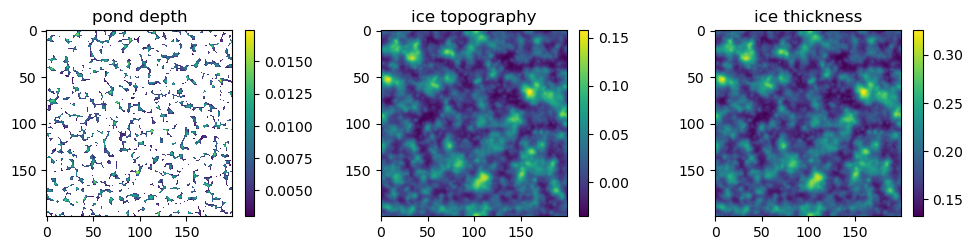

In [5]:
# plot some attributes
fig, axs = plt.subplots(1,3)
fig.set_size_inches(10, 2.5)

h_plot = axs[0].imshow(np.ma.masked_where(h<0.003, h))
axs[0].set_title('pond depth')
plt.colorbar(h_plot, ax=axs[0])

Ht_plot = axs[1].imshow(Ht)
axs[1].set_title('ice topography')
plt.colorbar(Ht_plot, ax=axs[1])

H_plot = axs[2].imshow(H)
axs[2].set_title('ice thickness')
plt.colorbar(H_plot, ax=axs[2])

plt.tight_layout()
plt.show()

## Ising model

In [6]:
# initialize Ising model
size = 1000
initial_water_fraction = 0.45
iceing_test = Iceing_model.iceing_model(initial_water_fraction, size)

In [7]:
# run the model
ponds, sums = iceing_test.run(15_000_000)

Text(0.5, 0, '10^6 iterations')

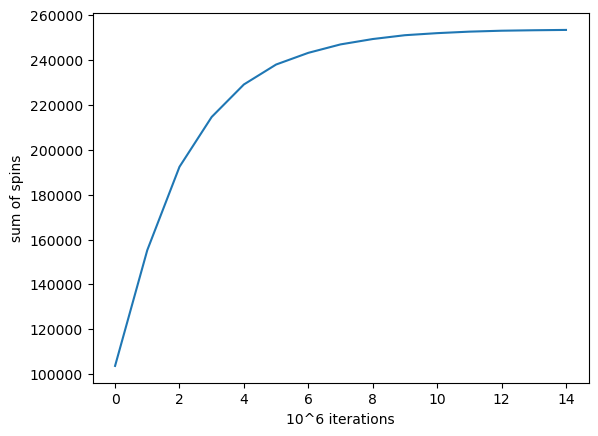

In [8]:
# check convergence
plt.plot(sums)
plt.ylabel('sum of spins')
plt.xlabel('10^6 iterations')

In [9]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'white'])
bounds=[-100,0,100]
norm = colors.BoundaryNorm(bounds, cmap.N)

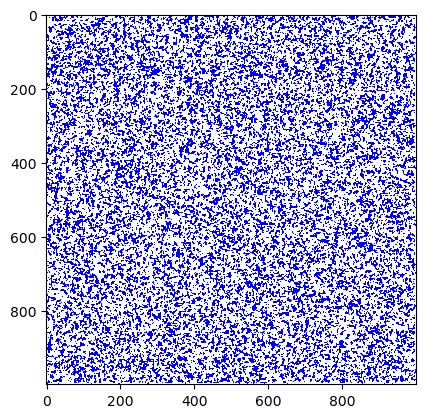

In [10]:
# plot ponds
plt.imshow(ponds, cmap=cmap, norm=norm)

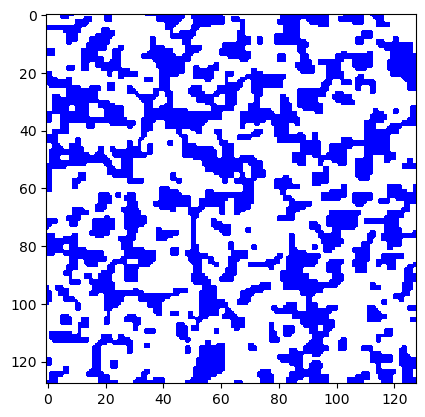

In [11]:
# zoom in and admire the fractals
plt.imshow(ponds[100:228,100:228], cmap=cmap, norm=norm)

## Evaluation of Ising

In [12]:
# get the area and perimeters
areas_ising, perimeters_ising = evaluation.perim_area(ponds, pond_val = -1, ice_val = 1)

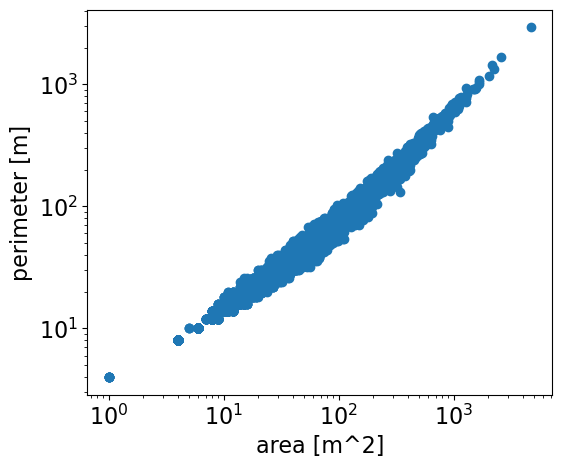

In [13]:
# make area perimeter plot
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 16})
plt.scatter(areas_ising, perimeters_ising)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')
plt.savefig("perimeter_area_scatter",bbox_inches="tight", dpi=300, transparent=True)

In [14]:
# get the lower edge of the area perimeter plot for fitting of fractal dimensions
low_areas, low_perimeters = evaluation.get_lowest(areas_ising, perimeters_ising, bins = 50)

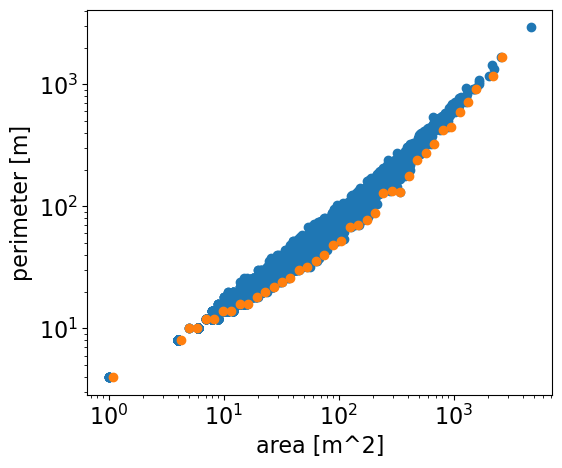

In [15]:
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 16})
plt.scatter(areas_ising, perimeters_ising)
plt.scatter(low_areas, low_perimeters)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')
plt.savefig("perimeter_area_scatter",bbox_inches="tight", dpi=300, transparent=True)

In [16]:
# display the (fitted) fractal dimensions
areas_dim, dimensions, _, areas_scatter, dimensions_scatter = evaluation.fractal_dim(ponds, -1, 1, 50)

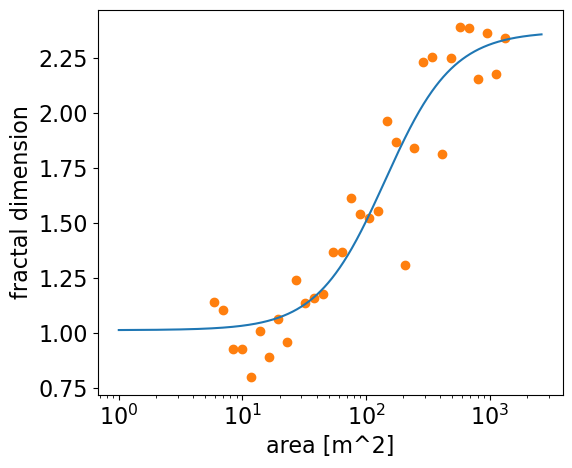

In [17]:
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 16})
plt.plot(areas_dim, dimensions)
plt.scatter(areas_scatter, dimensions_scatter, color = 'C1')
plt.xscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('fractal dimension')